In [60]:
import sys
!{sys.executable} -m pip install mysql-connector sqlalchemy
import pandas as pd
import mysql.connector
from sqlalchemy import create_engine
from config import *
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

  Using cached https://files.pythonhosted.org/packages/20/a1/b71d86cc8176892d9cc3de9aad4c118a9d61f99eeee8ab82e9d10e19a82b/fbprophet-0.2.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/b3/3c/dce0eae3f03bae8fc9af88e2dc12526081b53e4889a387f550d4daefe8db/pystan-2.17.1.0-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Running setup.py bdist_wheel for fbprophet ... error
  Complete output from command /usr/local/Cellar/python/3.6.3/bin/python3.6 -u -c "import setuptools, tokenize;__file__='/private/var/folders/ss/cg95h1zs60xgpbt4npp2hknw0000gn/T/pip-build-87ql3jtp/fbprophet/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /var/folders/ss/cg95h1zs60xgpbt4npp2hknw0000gn/T/tmpub0e695qpip-wheel- --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib
  creat

In [9]:
def split_dates(frame):
    dates = frame.DisDate
    split_dates = dates.apply(lambda x: x.split('/'))
    years_only = split_dates.apply(lambda x: not x[0] and not x[1])
    months_only = split_dates.apply(lambda x: not x[0] and not not x[1])
    full_dates = split_dates.apply(lambda x: all(x))
    #Accurate to years only, months only and days only respectively
    return frame[years_only], frame[months_only], frame[full_dates]

In [10]:
def is_date(row,year=None,month=None,day=None):
    retVal = True
    if year:
        retVal = retVal and row['DisDate'].split('/')[2] == str(year)
    if month:
        retVal = retVal and row['DisDate'].split('/')[1] == str(month).zfill(2)#Zero-Padding
    if day:
        retVal = retVal and row['DisDate'].split('/')[0] == str(day).zfill(2)#Zero-Padding
    return retVal

In [4]:
# years, months, days = split_dates(disaster_frame)

NameError: name 'disaster_frame' is not defined

# Prunes the columns from the comtrade API

In [11]:
def prune_columns(frame):
  important_columns = ['yr','rgCode', 'rtCode','rtTitle', 'ptCode', 'ptTitle', 'TradeQuantity', 'cmdCode', 'TradeValue']
  frame = frame[important_columns]
  frame['cmdCode'] = pd.to_numeric(frame['cmdCode'], errors='coerce', downcast='integer')
  frame.loc[frame['cmdCode'].isna(),'cmdCode'] = -1
  frame.cmdCode = frame.cmdCode.astype(int)
  return frame

In [12]:
def eng_connector(user=None,password=None,host=None,port=None,database=None):
    engine = create_engine('mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}'.format(user=username,password=password,host=hostname,port=port,database=database), echo=False)
    cnx = engine.connect()
    return engine, cnx

In [13]:
def get_trade_data(connector, query="select * from trades"):
    all_data = pd.read_sql(query,connector)
    #Converts the cmdCode series to the integer datatype
    all_data.cmdCode = pd.to_numeric(all_data.cmdCode,downcast='integer',errors='coerce')
    #Assert all of the cmdCodes are not null after attempting to cast them
    assert(all(all_data.cmdCode.notnull()))
    return all_data

In [49]:
def upload_db(frame,table,con,if_exists='append'):
  frame.to_sql(name=table, con=con, if_exists=if_exists, index=False) #if_exists 'append' or 'replace'

In [15]:
def getTrend(frame, country, commodity):
    return frame.loc[(frame['rt3ISO']==country)&(frame['cmdCode']==commodity)&(frame['ptCode']==0)&(frame['rgCode']==2),['yr','rt3ISO','cmdCode','TradeQuantity']]

In [16]:
def get_trend_table(iso,commodity):
    engine, con = eng_connector(user=username,password=password,host=hostname,port=port,database=database)
    trades = get_trade_data(con)
    country_isos = list(trades.rt3ISO.unique())
    commodities = list(trades.cmdCode.unique())
    assert iso in country_isos,"This iso isn't within the list of isos"
    assert commodity in commodities,"This commodity isn't within the list of commodities"
    return getTrend(trades,iso,commodity)

In [55]:
french_sugar = get_trend_table('FRA',1701)
french_sugar_quant = french_sugar.TradeQuantity
french_sugar_year = french_sugar.yr
french_sugar_year

366     1996
419     1997
502     1998
601     1999
710     2000
1596    2002
1940    2003
2347    2004
2796    2005
3084    2007
3421    2008
3841    2009
4316    2010
4605    2012
5005    2013
5458    2014
5940    2015
6123    2016
Name: yr, dtype: int64

In [53]:
coefficients, residuals, _, _, _ = np.polyfit(range(len(french_sugar)),french_sugar,1,full=True)
mse = residuals[0]/(len(french_sugar))
nrmse = np.sqrt(mse)/(french_sugar.max() - french_sugar.min())

In [54]:
print('Slope ' + str(coefficients[0]))
print('NRMSE: ' + str(nrmse))
print("Coeff1: ",coefficients[1])
range(len(french_sugar))

Slope -53153843.7915
NRMSE: 0.183028662392
Coeff1:  2835113653.67


range(0, 18)

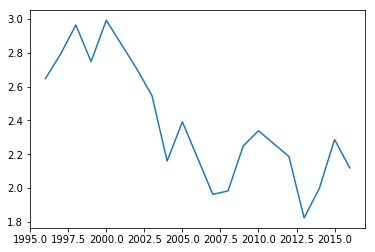

In [58]:
plt.plot(french_sugar_year,french_sugar_quant/1e9)
plt.show()

In [61]:
import fbprophet